# Modeling
In this exercise, we will predict activity on Cytochrome P450 ligands. We will use regresion forms of [SVM](https://en.wikipedia.org/wiki/Support-vector_machine) and [Random Forest](https://en.wikipedia.org/wiki/Random_forest). We will use again scikit [SVR](https://scikit-learn.org/stable/modules/svm.html#regression) and [RF](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest#sklearn.ensemble.RandomForestRegressor).

## Goals of the exercise
* Familiarize yourself with modeling. If mentioned models in this exercise are not enough, you can surely find more methods in scikit-learn. You can use another descriptors, e.g. fingerprints.
* Find some well predicting solution set of model and descriptors on your data

### Loading modules and functions

In [1]:
# loading moduiles and packages
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# plots
from matplotlib import pyplot
import seaborn

# other packages
import pandas as pd
import numpy as np
import csv
import re

RDKit WARNING: [20:48:00] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
# method used to remove salts from compaunds
sr = SaltRemover() 
m = Chem.MolFromSmiles("[Na+].C(=O)[O-]")
print(Chem.MolToSmiles(sr(m)))

O=C[O-]


In [3]:
# functions and variables used in the exercise
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        ('[n+;H]','n'), # Imidazoles
        ('[N+;!H0]','N'), # Amines
        ('[$([O-]);!$([O-][#7])]','O'), # Carboxylic acids and alcohols
        ('[S-;X1]','S'), # Thiols
        ('[$([N-;X2]S(=O)=O)]','N'), # Sulfonamides
        ('[$([N-;X2][C,N]=C)]','N'), # Enamines
        ('[n-]','[nH]'), # Tetrazoles
        ('[$([S-]=O)]','S'), # Sulfoxides
        ('[$([N-]C=O)]','N'), # Amides
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None
    
def get_results(model, data, descriptors, predicted_value):
    res = pd.DataFrame(model.predict(data[descriptors])).join(data[[predicted_value, "source"]])
    res.columns = ["Prediction", predicted_value, "Source"]
    print(f"""Average error: {(res["Prediction"]-res[predicted_value]).abs().mean()}""")
    return res

### Data loading and preprocessing

While loading data I used standardize function, which allows to neutrilize charges and remove salts from molecules. Below it is also seen that drugbank dataset was not loaded.

In [4]:
## Data loading  
float_pattern = re.compile("[0-9]+(\.[0-9]*)?")
lip_func = [("HBA", Lipinski.NumHAcceptors), ("HBD", Lipinski.NumHDonors), ("MW", Descriptors.ExactMolWt),
            ("LogP", Descriptors.MolLogP), ("TPSA", rdMolDescriptors.CalcTPSA), ("RB", Lipinski.NumRotatableBonds)]

with open("Cytochrome_P450_targets.csv") as inp:
    cytc = [row for row in csv.DictReader(inp, delimiter=";", quotechar='"')]
    for m in cytc:
        mol = Chem.MolFromSmiles(m["Smiles"])
        if mol:
            m["rdmol"] = mol
            stdmol = standardize(mol) # at this step I removed salts and neutrilized charges
            m["source"] = "Cytochrome P450"
            m["pChEMBL Value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
            m["std_rdmol"] = None
            m["Standard Value"] = float(m["Standard Value"]) if float_pattern.match(m["Standard Value"]) else np.NaN
        if stdmol:
            m["std_rdmol"] = stdmol
            m["std_smiles"] = Chem.MolToSmiles(stdmol)
            m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["std_rdmol"],2,nBits=1024)
            for f in lip_func:
                m[f[0]] = f[1](m["std_rdmol"])

In [5]:
cytc[:2]

[OrderedDict([('Molecule ChEMBL ID', 'CHEMBL3109802'),
              ('Molecule Name', 'TBA-7371'),
              ('Molecule Max Phase', '2'),
              ('Molecular Weight', '355.40'),
              ('#RO5 Violations', '0'),
              ('AlogP', '1.22'),
              ('Compound Key', '12'),
              ('Smiles', 'COc1ncnc(Cn2cc(C(=O)NCCO)c3ncc(C)cc32)c1C'),
              ('Standard Type', 'IC50'),
              ('Standard Relation', "'>'"),
              ('Standard Value', 50000.0),
              ('Standard Units', 'nM'),
              ('pChEMBL Value', 0),
              ('Data Validity Comment', ''),
              ('Comment', ''),
              ('Uo Units', 'UO_0000065'),
              ('Ligand Efficiency BEI', ''),
              ('Ligand Efficiency LE', ''),
              ('Ligand Efficiency LLE', ''),
              ('Ligand Efficiency SEI', ''),
              ('Potential Duplicate', 'True'),
              ('Assay ChEMBL ID', 'CHEMBL3292128'),
              ('Assay Descrip

In [6]:
# create dataframe (I did not load drugbank here to create df which will be further used for predictions)
df = pd.DataFrame([m for m in cytc if m["std_rdmol"]], columns=["Smiles", "std_smiles", "source", "rdmol", "std_rdmol", "fps", "Standard Value", "Standard Units", "pChEMBL Value", *(f[0] for f in lip_func)])
df.reset_index(level=0, inplace=True)
df = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["std_rdmol"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))]))

In [7]:
# let's also check if dataframe have missing values
print(df.isnull().sum())

index               0
Smiles              0
std_smiles          0
source              0
rdmol               0
std_rdmol           0
fps                 0
Standard Value    982
Standard Units      0
pChEMBL Value       0
HBA                 0
HBD                 0
MW                  0
LogP                0
TPSA                0
RB                  0
MQN_1               0
MQN_2               0
MQN_3               0
MQN_4               0
MQN_5               0
MQN_6               0
MQN_7               0
MQN_8               0
MQN_9               0
MQN_10              0
MQN_11              0
MQN_12              0
MQN_13              0
MQN_14              0
MQN_15              0
MQN_16              0
MQN_17              0
MQN_18              0
MQN_19              0
MQN_20              0
MQN_21              0
MQN_22              0
MQN_23              0
MQN_24              0
MQN_25              0
MQN_26              0
MQN_27              0
MQN_28              0
MQN_29              0
MQN_30    

We can see that there are some missing values in the dataset, so we can fill them with max value and then we can keep analyzing. After that, let's look at the first few rows.

In [8]:
df.head(3)

,index,Smiles,std_smiles,source,rdmol,std_rdmol,fps,Standard Value,Standard Units,pChEMBL Value,...,MQN_33,MQN_34,MQN_35,MQN_36,MQN_37,MQN_38,MQN_39,MQN_40,MQN_41,MQN_42
0,0,COc1ncnc(Cn2cc(C(=O)NCCO)c3ncc(C)cc32)c1C,COc1ncnc(Cn2cc(C(=O)NCCO)c3ncc(C)cc32)c1C,Cytochrome P450,<rdkit.Chem.rdchem.Mol object at 0x7ff64d0ee800>,<rdkit.Chem.rdchem.Mol object at 0x7ff64edc3080>,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",50000.0,nM,0.0,...,0,0,1,2,0,0,0,0,2,1
1,1,O=C(Nc1ccc(F)cn1)c1cc(Oc2cncc(F)c2)cn2cnnc12,O=C(Nc1ccc(F)cn1)c1cc(Oc2cncc(F)c2)cn2cnnc12,Cytochrome P450,<rdkit.Chem.rdchem.Mol object at 0x7ff64edc36c0>,<rdkit.Chem.rdchem.Mol object at 0x7ff64edc3a80>,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30000.0,nM,0.0,...,0,0,1,3,0,0,0,0,2,1
2,2,C[C@@](CCN1Cc2cc(C#CC#CC3CN(CCF)C3)cn2C1=O)(C(...,C[C@@](CCN1Cc2cc(C#CC#CC3CN(CCF)C3)cn2C1=O)(C(...,Cytochrome P450,<rdkit.Chem.rdchem.Mol object at 0x7ff64edc3b20>,<rdkit.Chem.rdchem.Mol object at 0x7ff64edc7030>,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",50000.0,nM,0.0,...,0,1,2,0,0,0,0,0,2,1


In [9]:
mx = df["Standard Value"].max()+1
df["Standard Value"] = df["Standard Value"].fillna(mx+1)

For my predictions I will not use standard value, instead I will use pChEMBL value. Lets's also explain what is the difference between Standard Value and pChEMBL value. pChEMBL value allows a number of roughly comparable measures of half-maximal response concentration/potency/affinity to be compared on a negative logarithmic scale. For example, an IC50 measurement of 1nM would have a pChEMBL value of 9. Standard IC50 value can have different values and the mistake I did by hanfding in my dataset before is that I havent check if the unit is the same for the value. I will do it now and maybe reduce my dataset to one unit.

In [10]:
# checking IC50 units 
df["Standard Units"].unique()

array(['nM', '', 'min', 'ug.mL-1'], dtype=object)

I found out that some molecules had IC50 in µM, some have missing values and some have dash instead. Let's clean it!

In [11]:
len(df)

5771

In [12]:
df = df[df["Standard Units"] == "nM"]

In [13]:
len(df)

4784

In [14]:
# the maximum pChEMBL values as I discussed is 9. Let's check if it works out for my dataset.
mxp = df["pChEMBL Value"].max()
mxp

9.3

To be honest I was not sure why one was added to maximum IC50 value, I am not sure if I have to do it here as well and I am not sure if 9.3 is not a weird value why Google says that the maximum is 9. Let;s just increase treshold by a point as we did for Standard value.

In [15]:
mxp_val = mxp + 0.1
mxp_val

9.4

In [16]:
minp_val = df["pChEMBL Value"].min()
minp_val

0.0

# Predictions on MQN descriptorech

## Support Vector Regression (SVR)

Let's first try a Support Vector Machine regression version of predictions. We will predict on pChEMBL value instead of Standard value. The predictions on Standard IC50 value did not work out well.

In [17]:
svr = svm.SVR()
svr.fit(df[df["pChEMBL Value"]<mxp_val][(f"MQN_{x}" for x in range(1, 43))], df[df["pChEMBL Value"]<mxp_val]["pChEMBL Value"])

SVR()

In [18]:
res = pd.DataFrame(svr.predict(df[(f"MQN_{x}" for x in range(1, 43))])).join(df[["pChEMBL Value"]])
res.columns = ["Prediction", "pChEMBL Value"] #We dont need source column here as it is identical it is just my dataset
(res["Prediction"]-res["pChEMBL Value"]).abs().mean()

2.757721698917371

In [19]:
# Let's use some function to get results, we will have lots of models
res = get_results(svr, df, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value") 

Average error: 2.757721698917371


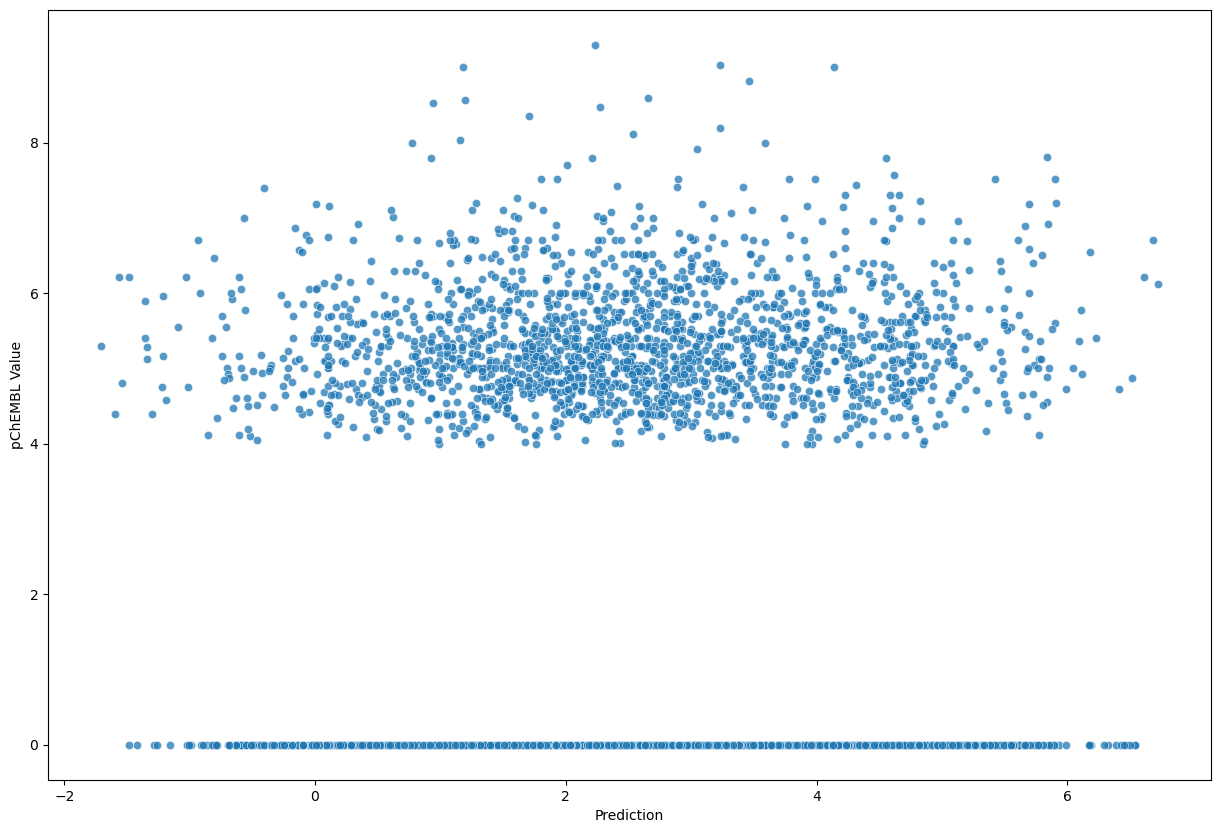

In [20]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )
pyplot.show()

## Random Forest Regressor

In [21]:
rf = ensemble.RandomForestRegressor()
rf.fit(df[df["pChEMBL Value"]<mxp_val][(f"MQN_{x}" for x in range(1, 43))], df[df["pChEMBL Value"]<mxp_val]["pChEMBL Value"])

RandomForestRegressor()

In [22]:
res_rf = get_results(rf, df, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error: 2.7406820279967987


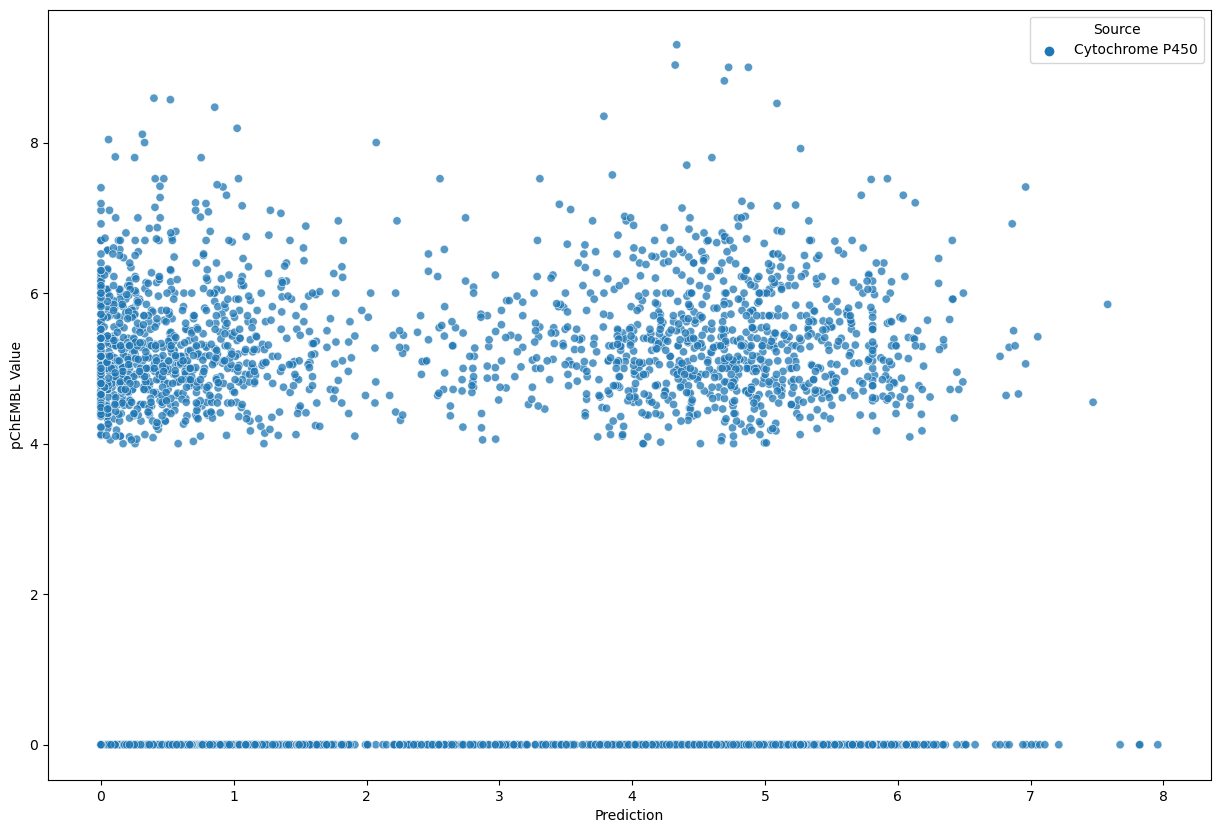

In [23]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_rf,
                      hue="Source",
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )
pyplot.show()

## SVR

In [24]:
svr_p = svm.SVR()
svr_p.fit(df[df["pChEMBL Value"]>0][(f"MQN_{x}" for x in range(1, 43))], df[df["pChEMBL Value"]>0]["pChEMBL Value"])

SVR()

In [25]:
res_svr_p = get_results(svr_p, df, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error: 2.943745692803939


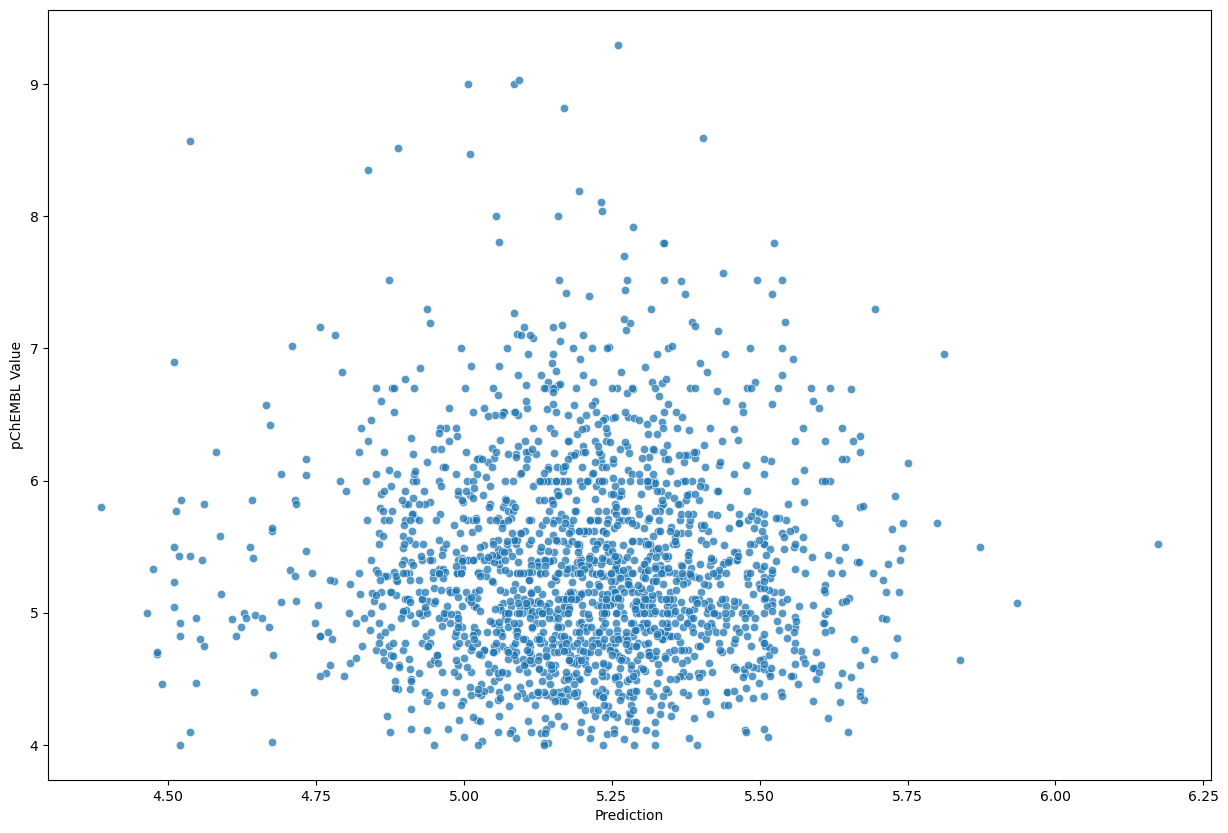

In [26]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_p[res_svr_p["pChEMBL Value"]>0],
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )
pyplot.show()

## SVR with PCA

In [27]:
norm = preprocessing.normalize(df[(f"MQN_{x}" for x in range(1, 43))])
pca = decomposition.PCA(n_components=42)
pca.fit(norm)
df_pca = df.join(pd.DataFrame(pca.transform(norm), columns=[f"nPCA_{x}" for x in range(1, 43)]),how='left')

In [28]:
print(df.isnull().sum())

index             0
Smiles            0
std_smiles        0
source            0
rdmol             0
std_rdmol         0
fps               0
Standard Value    0
Standard Units    0
pChEMBL Value     0
HBA               0
HBD               0
MW                0
LogP              0
TPSA              0
RB                0
MQN_1             0
MQN_2             0
MQN_3             0
MQN_4             0
MQN_5             0
MQN_6             0
MQN_7             0
MQN_8             0
MQN_9             0
MQN_10            0
MQN_11            0
MQN_12            0
MQN_13            0
MQN_14            0
MQN_15            0
MQN_16            0
MQN_17            0
MQN_18            0
MQN_19            0
MQN_20            0
MQN_21            0
MQN_22            0
MQN_23            0
MQN_24            0
MQN_25            0
MQN_26            0
MQN_27            0
MQN_28            0
MQN_29            0
MQN_30            0
MQN_31            0
MQN_32            0
MQN_33            0
MQN_34            0


In [29]:
df_pca = df_pca.dropna()

In [30]:
svr_np = svm.SVR()
svr_np.fit(df_pca[df_pca["pChEMBL Value"]<mxp_val][(f"nPCA_{x}" for x in range(1, 43))], df_pca[df_pca["pChEMBL Value"]<mxp_val]["pChEMBL Value"])

SVR()

In [31]:
res_svr_np = res = get_results(svr_np, df_pca, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error: 2.644986564239326


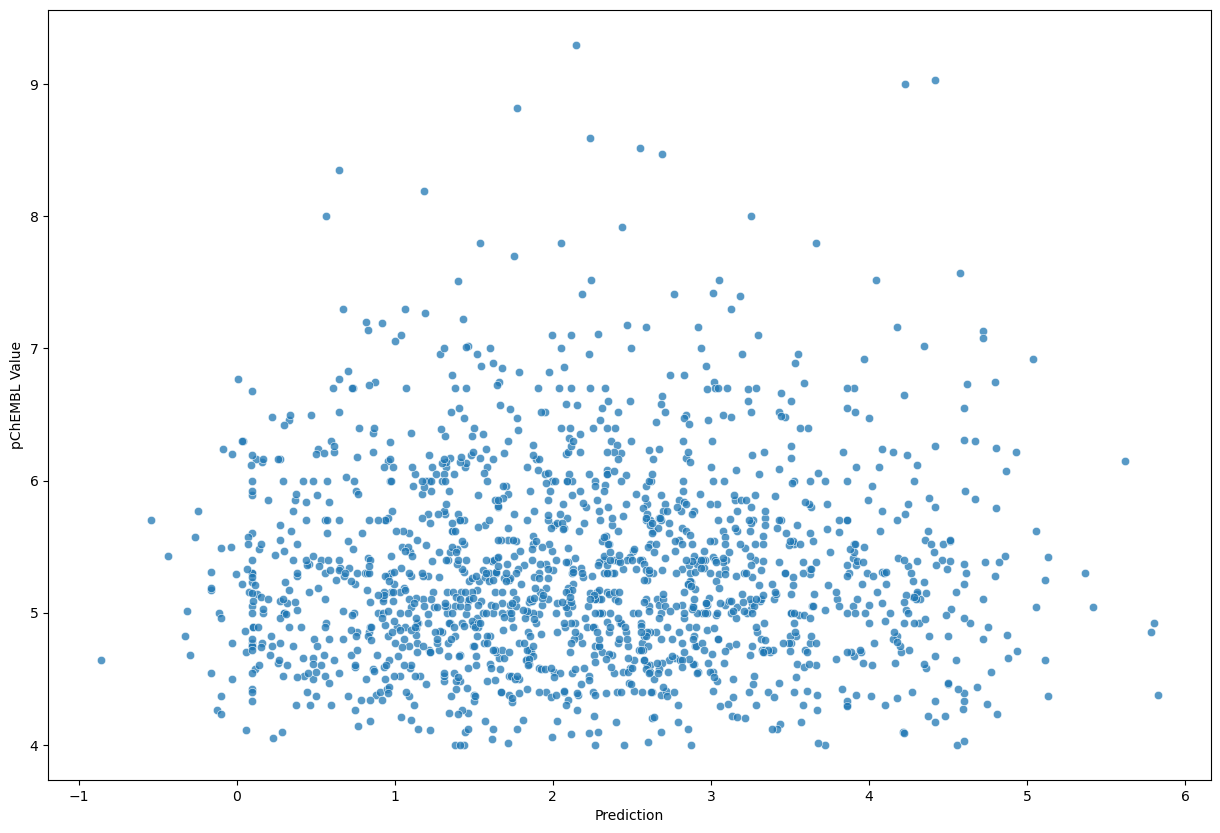

In [32]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=res_svr_np[res_svr_np["pChEMBL Value"]>0],
                      legend="brief",
                      ax=ax,
                      alpha=0.75)
pyplot.show()

As we can see from above, SVR with PCA so far showed the best result. Let's try some other kernels.

In [33]:
# Polynomial
svr_poly = svm.SVR(kernel = 'poly')
svr_poly.fit(df_pca[df_pca["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df_pca[df_pca["Standard Value"]<mx]["pChEMBL Value"])

SVR(kernel='poly')

In [34]:
res_svr_np = get_results(svr_poly, df_pca, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error: 2.6552837545037344


In [35]:
# RBF
svr_rbf = svm.SVR(kernel = 'rbf')
svr_rbf.fit(df_pca[df_pca["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df_pca[df_pca["Standard Value"]<mx]["pChEMBL Value"])

SVR()

In [36]:
res_svr_np = get_results(svr_rbf, df_pca, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error: 2.644986564239326


In [37]:
# Linear
svr_lin = svm.SVR(kernel = 'linear')
svr_lin.fit(df_pca[df_pca["Standard Value"]<mx][(f"nPCA_{x}" for x in range(1, 43))], df_pca[df_pca["Standard Value"]<mx]["pChEMBL Value"])

SVR(kernel='linear')

In [38]:
res_svr_np = get_results(svr_lin, df_pca, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error: 2.6419268447421747


In [39]:
# Sigmoid
svr_np = svm.SVR(kernel='sigmoid')
svr_np.fit(df_pca[df_pca["Standard Value"]<mx][(f"MQN_{x}" for x in range(1, 43))], df_pca[df_pca["Standard Value"]<mx]["Standard Value"])

SVR(kernel='sigmoid')

In [40]:
res_svr_np = get_results(svr_np, df_pca, (f"nPCA_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error: 10042.09908613697


We can see that other kernels did not improve the results.

## Test and train data
So, we divide our data in some ration (default is 75:25, but 80:20-70:30 is usually OK)

In [41]:
trainset, testset = ms.train_test_split(df_pca[df_pca["pChEMBL Value"]>0])

In [42]:
trainset.reset_index(inplace=True)
testset.reset_index(inplace=True)

In [43]:
len(trainset), len(testset)

(1456, 486)

In [44]:
finaly_good_model = svm.SVR()
finaly_good_model.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["pChEMBL Value"])

SVR()

In [45]:
train_results = get_results(finaly_good_model, trainset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error: 0.5376513613854079


In [46]:
test_results = get_results(finaly_good_model, testset, (f"MQN_{x}" for x in range(1, 43)), "pChEMBL Value")

Average error: 0.5574038881986468


In [47]:
print("R^2: %0.2f" % finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"]))
print("R: %0.2f" % np.sqrt(finaly_good_model.score(testset[(f"MQN_{x}" for x in range(1, 43))], testset["pChEMBL Value"])))
print("MSE: %0.2f" %  mean_squared_error(test_results["Prediction"], test_results["pChEMBL Value"]))

R^2: 0.08
R: 0.28
MSE: 0.55


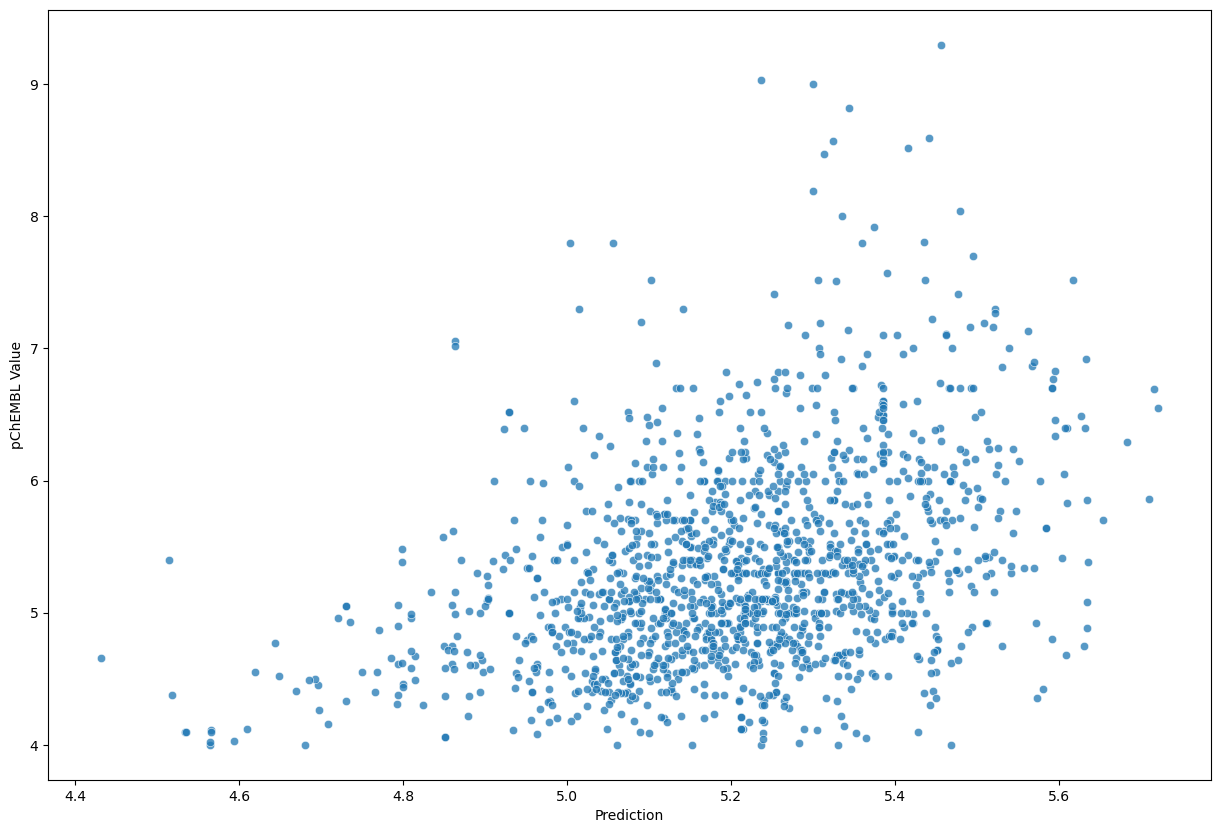

In [48]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=train_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )
pyplot.show()

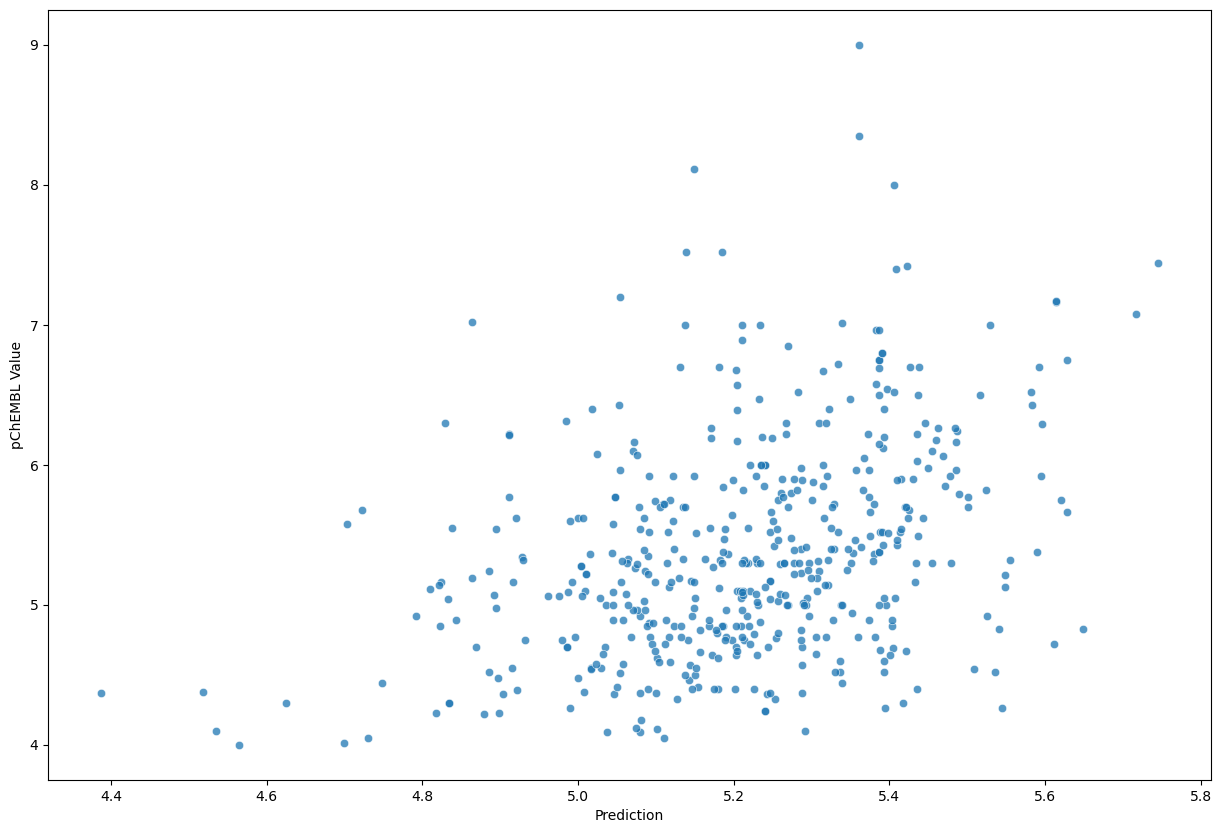

In [49]:
fig, ax = pyplot.subplots(figsize=(15,10))
p=seaborn.scatterplot(x="Prediction",
                      y="pChEMBL Value",
                      data=test_results,
                      legend="brief",
                      ax=ax,
                      alpha=0.75
                     )
pyplot.show()

## Overview of predictions on MQN descriptors

Different models performance for prediction of pChEMBL value (average error):

* Random forest - 2.73
* SVR - 2.75
* SVR with PCA - 2.64
* SVR with PCA (different kernels) 2.64 - 2.65


SVR with PCA (with RBF kernel) shows the best performance on my data (to predict pChEMBL value) value with the following estimator measures:

* R^2: 0.10
* R: 0.31
* MSE: 0.54
* Average error: 2.64

Well we can conclude from this part that predictions on MQN descriptotrech did not work well.

# Prediction on Fingerprints

As seen from above the predictions on MQN descriptors did not work out well so we can now try to predict on fibngerprints. 

In [50]:
# preparing data
df["Molecule"] = [Chem.MolFromSmiles(mol) for mol in df["std_smiles"]] 
df['bin'] = [np.array(Chem.GetMorganFingerprintAsBitVect(i,2, nBits=1024)) for i in df['Molecule']]

# let's first try to predict on standard IC50 value and then on pChEMBL value
data = df[['index', 'bin', 'Standard Value']]
data.head()

,index,bin,Standard Value
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",50000.0
1,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30000.0
2,2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",50000.0
3,3,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7700.0
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4000.0


In [51]:
# preparing train and the test set
train, test = ms.train_test_split(data, test_size=0.2, random_state=0)

In [52]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [53]:
X_train = train.bin.tolist()
y_train = train['Standard Value'].tolist()

x_pred = test.bin.tolist()
y_val = test['Standard Value'].tolist()

## Random forest - Standard Value

In [54]:
rfr = ensemble.RandomForestRegressor(n_estimators=101, max_features=32, max_depth=4, random_state=0)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, max_features=32, n_estimators=101,
                      random_state=0)

In [55]:
y_pred = rfr.predict(x_pred)

In [56]:
print("MSE: %0.2f" %  mean_squared_error(y_pred, y_val))

MSE: 50958931390.70


## SVM - Standard Value

In [57]:
svr = svm.SVR()
svr.fit(X_train, y_train)

SVR()

In [58]:
y_pred_svr = svr.predict(x_pred)

In [59]:
print("MSE: %0.2f" %  mean_squared_error(y_pred_svr, y_val))

MSE: 7715972116.02


We can see that both SVM and SVM did not show well in prediction of Standard IC50 Value. We can now try to predict on pCHEML value.

## pChEMBL Value

In [60]:
# preprocessing of data
data_pChEMBL = df[['index', 'bin', 'pChEMBL Value']]
data_pChEMBL.head()

,index,bin,pChEMBL Value
0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.00
1,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00
2,2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00
3,3,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.11
4,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.40


In [61]:
# preparing train and the test set
train_p, test_p = ms.train_test_split(data_pChEMBL, test_size=0.2, random_state=0)

In [62]:
train_p = train_p.reset_index(drop=True)
test_p = test_p.reset_index(drop=True)

In [63]:
X_train_p = train_p.bin.tolist()
y_train_p = train_p['pChEMBL Value'].tolist()

x_pred_p = test_p.bin.tolist()
y_val_p = test_p['pChEMBL Value'].tolist()

## Random Forest - pChEMBL Value

In [64]:
rfr = ensemble.RandomForestRegressor(n_estimators=101, max_features=32, max_depth=4, random_state=0)
rfr.fit(X_train_p, y_train_p)

RandomForestRegressor(max_depth=4, max_features=32, n_estimators=101,
                      random_state=0)

In [65]:
y_pred_p = rfr.predict(x_pred_p)

In [66]:
print("MSE: %0.2f" %  mean_squared_error(y_pred_p, y_val_p))

MSE: 6.78


## SVM - pChEMBL Value

In [67]:
svr = svm.SVR()
svr.fit(X_train_p, y_train_p)

SVR()

In [68]:
y_pred_svr_p = svr.predict(x_pred_p)

In [69]:
print("MSE: %0.2f" %  mean_squared_error(y_pred_svr_p, y_val))

MSE: 8121022665.71


From above we can see that the best performance by predicting pChEMBL was done by Random Forest Regression. Let's also try to tune some hyperparameters for that model with KFold cross validation.

In [77]:
# splitting dataset into train and test
X_train, X_test, y_train, y_test = ms.train_test_split(data_pChEMBL['bin'],data_pChEMBL['pChEMBL Value'] ,test_size=0.2, random_state=0) 

X_train_final = X_train.tolist()
y_train_final = y_train.tolist()

# let's try to look at the depth and n_estimators
param_grid = {
    "n_estimators": range(1,100,5),
    "max_depth": range(1,10)
}

In [79]:
from sklearn.model_selection import RandomizedSearchCV

rf = ensemble.RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train_final, y_train_final)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(1, 10),
                                        'n_estimators': range(1, 100, 5)},
                   random_state=42, verbose=2)

In [80]:
rf_random.best_params_

{'n_estimators': 56, 'max_depth': 9}

In [81]:
best_model = rf_random.best_estimator_

In [83]:
y_pred_final = best_model.predict(X_test.tolist())

In [84]:
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_final))

Mean Squared Error: 5.379467920397257


## Conclusion

I could a little bit improve Random forest regression with hyperparameter tunning and end up with MSE 5.38 it is still very low for a good model, though I have no more time to test more models as I am in a hurry for an exam.